# Dask at mistral
## login
Aaron: Direct Jupyter Script from https://www.dkrz.de/up/systems/mistral/programming/jupyter-notebook; loads anaconda3 with my_jupyter environment

# Whats there

In [3]:
import multiprocessing
multiprocessing.cpu_count()

48

In [4]:
import psutil
psutil.virtual_memory()

svmem(total=67309031424, available=62845401088, percent=6.6, used=4359716864, free=62524395520, active=334802944, inactive=341700608, buffers=8638464, cached=416280576, shared=1871872, slab=2817179648)

In [5]:
!which conda
!conda --version

/work/mh0727/m300524/anaconda3/condabin/conda
conda 4.6.2


In [6]:
!which python
!python --version

/work/mh0727/m300524/anaconda3/envs/my_jupyter/bin/python
Python 3.6.7 :: Anaconda, Inc.


In [7]:
!which bokeh
!bokeh --version

/work/mh0727/m300524/anaconda3/envs/my_jupyter/bin/bokeh
0.13.0


In [8]:
!conda list | grep -i dask

dask                      1.0.0                      py_0    conda-forge
dask-core                 1.0.0                      py_0    conda-forge
dask-jobqueue             0.4.1                      py_0    conda-forge
dask-labextension         0.3.1                    pypi_0    pypi


## Goals
- use of diagnostics (https://distributed.readthedocs.io/en/latest/web.html) to identify bottlenecks
- use of parallel computing
- use of lazy data ()
- use of SLURM

# Setup 

In [9]:
# Starting the Dask Client is optional. It will provide a dashboard which is useful to gain insight on the computation.
from dask.distributed import Client, progress, LocalCluster
client = Client(n_workers=4, threads_per_worker=5, memory_limit='2GB')
#cluster=LocalCluster()
#cluster.scale(8)
#client = Client(cluster)

In [11]:
client.has_what()

{'tcp://127.0.0.1:35978': (),
 'tcp://127.0.0.1:36094': (),
 'tcp://127.0.0.1:39115': (),
 'tcp://127.0.0.1:46052': ()}

# dask interface diagnostics

access from jupyter: you might need to change 8888 to your port
- http://localhost:8888/proxy/8787/status


- install dask labextension
- open: 
    - task stream
    - dask graph
    - dask progress
    - dask workers

# xarray example
Grabbing data from the Large Ensemble

In [30]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
%matplotlib inline

LE='/work/mh1007/mpiesm1/experiments'
pre='lkm0'

In [31]:
import os,glob

In [38]:
def get_path(ens,model,outdatatype):
    #endyear=startyear+length
    run_id = pre+str(ens)
    return LE+'/'+run_id+'/outdata/'+model+'/'+run_id+'_'+model+'_'+outdatatype+'_'+'*.nc'

In [39]:
get_path(101,'hamocc','data_2d_mm')

'/work/mh1007/mpiesm1/experiments/lkm0101/outdata/hamocc/lkm0101_hamocc_data_2d_mm_*.nc'

In [29]:
ds = xr.open_mfdataset(get_path(101,'mpiom','data_2d_mm')).squeeze()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [7]:
ds.nbytes/1e9

1.217414104

load first x years of LE in y members

In [40]:
l=[]
for ens in range(101,111):
    print(ens)
    l.append(xr.open_mfdataset(get_path(ens,'mpiom','data_2d_mm')).squeeze())

ds_ens = xr.concat(l,dim='ensemble')

del l

101
102
103
104
105
106
107
108
109
110


In [41]:
print(ds_ens.nbytes/1e9,'GB')

189.77678812 GB


## Ensemble and time mean

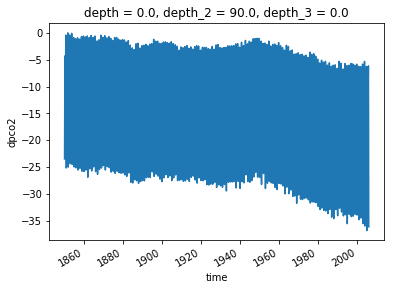

In [43]:
ds_ens['tos'].mean(['time','ensemble']).plot()

## Global timeseries

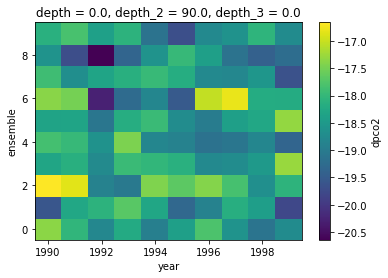

In [22]:
ds_ens['tos'].groupby('time.year').mean('time').mean(['y','x']).plot()

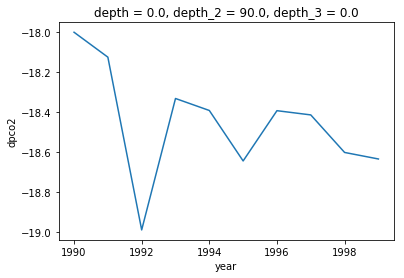

In [25]:
ds_ens['tos'].groupby('time.year').mean('time').mean(['ensemble','x','y']).plot()

## GE control 

In [8]:
get_path('001','hamocc','data_2d_mm')

'/work/mh1007/mpiesm1/experiments/lkm0001/outdata/hamocc/lkm0001_hamocc_data_2d_mm_*.nc'

In [ ]:
control = xr.open_mfdataset(get_path('001','mpiom','data_2d_mm'))

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:55894 remote=tcp://127.0.0.1:36131>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:55900 remote=tcp://127.0.0.1:36131>
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into

In [ ]:
control.nbytes/1e9

In [13]:
xr.enable_cftimeindex = True

In [ ]:
control.data_vars

# SLURM
Another client shouldn't be started to get the diagnostics working.

In [126]:
from dask_jobqueue import SLURMCluster

In [128]:
cluster = SLURMCluster(processes=6, cores=4, memory="4GB",account='mh0727',partition='compute')
cluster.scale(10)  # this may take a few seconds to launch
from dask.distributed import Client
client = Client(cluster)

/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)
sbatch: error: Batch job submission failed: Invalid account or account/partition combination specified

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x2ac6b40231e0>, 10)
Traceback (most recent call last):
  File "/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/work/mh0727/m300524/anaconda3/envs/my_jupyter/lib/python3.6/site-packages/dask_jobqueue/core.py", line 375, in scale_up
  

In [130]:
client

Client Scheduler: tcp://10.50.40.47:46497 Dashboard: http://10.50.40.47:39681/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
